## Imports

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

## Data loading

In [2]:
URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
zip_dir = tf.keras.utils.get_file('cats_and_dogs_filtered.zip', origin=URL, extract=True)

In [3]:
zip_dir_base = os.path.dirname(zip_dir)
!find $zip_dir_base -type d -print

/root/.keras/datasets
/root/.keras/datasets/cats_and_dogs_filtered
/root/.keras/datasets/cats_and_dogs_filtered/train
/root/.keras/datasets/cats_and_dogs_filtered/train/dogs
/root/.keras/datasets/cats_and_dogs_filtered/train/cats
/root/.keras/datasets/cats_and_dogs_filtered/validation
/root/.keras/datasets/cats_and_dogs_filtered/validation/dogs
/root/.keras/datasets/cats_and_dogs_filtered/validation/cats


In [4]:
zip_dir_base

'/root/.keras/datasets'

In [5]:
base_dir = Path(Path(zip_dir_base)/'cats_and_dogs_filtered')

train_dir = base_dir/'train'
validation_dir = base_dir/'validation'

train_dogs_dir = train_dir/'dogs'
train_cats_dir = train_dir/'cats'
validation_dogs_dir = validation_dir/'dogs'
validation_cats_dir = validation_dir/'cats'

## Setting model parameters

In [6]:
BATCH_SIZE = 100
IMG_SHAPE = 150
EPOCHS = 35

In [7]:
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)

In [8]:
train_data_gen = train_image_generator.flow_from_directory(
    batch_size=BATCH_SIZE,
    directory=train_dir,
    shuffle=True,
    target_size=(IMG_SHAPE, IMG_SHAPE),
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.


In [9]:
validation_data_gen = validation_image_generator.flow_from_directory(
    directory=validation_dir,
    target_size=(IMG_SHAPE, IMG_SHAPE),
    class_mode='binary',
    batch_size=BATCH_SIZE,
    shuffle=True
)

Found 1000 images belonging to 2 classes.


## Visualizing training examples

In [10]:
sample_training_images, _ = next(train_data_gen) 

In [11]:
len(sample_training_images)

100

100, because of the batch size being 100

In [12]:
def plot_images(images_arr):
  fig, axes = plt.subplots(1, 5, figsize=(20, 20))
  axes = axes.flatten()
  for img, ax in zip(images_arr, axes):
      ax.imshow(img)
  plt.tight_layout()
  plt.show()

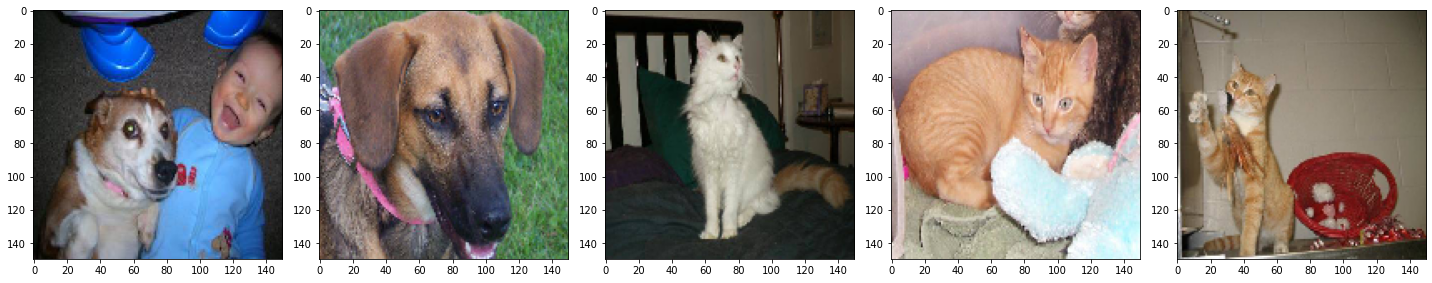

In [13]:
plot_images(sample_training_images[:5])

## Model creation

In [14]:
cnn_model = tf.keras.Sequential([
                                 tf.keras.layers.Conv2D(32, (3, 3), input_shape=(IMG_SHAPE, IMG_SHAPE, 3), activation=tf.keras.activations.relu),
                                 tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

                                 tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.relu),
                                 tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

                                 tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.relu),
                                 tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

                                 tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.relu),
                                 tf.keras.layers.MaxPool2D(pool_size=(2,2)),

                                 tf.keras.layers.Flatten(),
                                 tf.keras.layers.Dense(512, activation='relu'),
                                 tf.keras.layers.Dense(2, activation='softmax')
])

In [15]:
cnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss=tf.keras.losses.sparse_categorical_crossentropy,
                  metrics=['accuracy'])

In [16]:
history = cnn_model.fit_generator(
    train_data_gen,
    epochs=EPOCHS,
    verbose=0,
    validation_data=validation_data_gen
)

Instructions for updating:
Please use Model.fit, which supports generators.


## Visualizing results of the training

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

Text(0.5, 1.0, 'Training and Validation Loss')

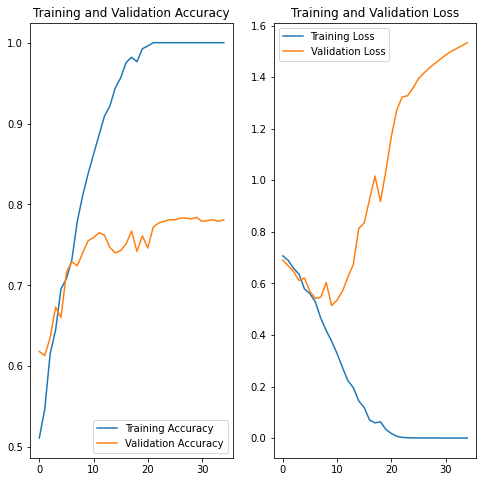

In [18]:
plt.figure(figsize=(8, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend()
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.title("Training and Validation Loss")

We can clearly see that the validation accuracy has stopped increasing after 20th epoch and the validation loss is increasing after that epoch. This indicates overfitting!

## Add Image Augmentation in the Image generator

In [24]:
image_gen_train = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

In [25]:
train_data_gen = image_gen_train.flow_from_directory(
    batch_size=BATCH_SIZE,
    directory=train_dir,
    shuffle=True,
    target_size=(IMG_SHAPE, IMG_SHAPE),
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.


## Creating validation data generator

In [26]:
image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(batch_size=BATCH_SIZE,
                                                 directory=validation_dir,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='binary')

Found 1000 images belonging to 2 classes.


## Define model with dropouts

In [27]:
EPOCHS = 100

In [28]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2)
])

In [29]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [31]:
history = model.fit(
    train_data_gen,
    epochs=EPOCHS,
    validation_data=val_data_gen
)

Epoch 1/100
20/20 [==============================] - 17s 866ms/step - loss: 0.7188 - accuracy: 0.4900 - val_loss: 0.6895 - val_accuracy: 0.5000
Epoch 2/100
20/20 [==============================] - 17s 854ms/step - loss: 0.6921 - accuracy: 0.5185 - val_loss: 0.6929 - val_accuracy: 0.5040
Epoch 3/100
20/20 [==============================] - 17s 837ms/step - loss: 0.6912 - accuracy: 0.5255 - val_loss: 0.6856 - val_accuracy: 0.5910
Epoch 4/100
20/20 [==============================] - 17s 828ms/step - loss: 0.6887 - accuracy: 0.5495 - val_loss: 0.6772 - val_accuracy: 0.5830
Epoch 5/100
20/20 [==============================] - 16s 823ms/step - loss: 0.6788 - accuracy: 0.5760 - val_loss: 0.6864 - val_accuracy: 0.5620
Epoch 6/100
20/20 [==============================] - 16s 817ms/step - loss: 0.6859 - accuracy: 0.5525 - val_loss: 0.6762 - val_accuracy: 0.6010
Epoch 7/100
20/20 [==============================] - 16s 814ms/step - loss: 0.6722 - accuracy: 0.6155 - val_loss: 0.6405 - val_accuracy:

## Visualise results of training

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

Text(0.5, 1.0, 'Training and Validation Loss')

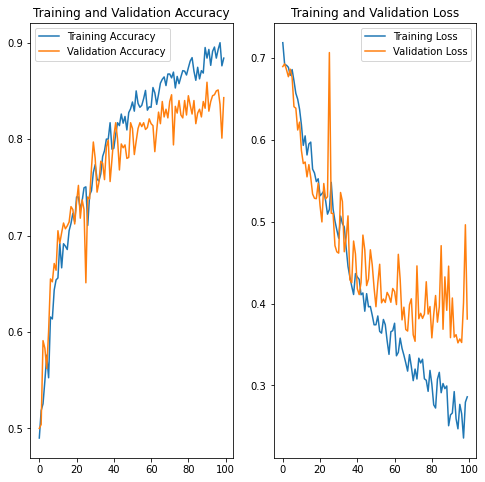

In [33]:
plt.figure(figsize=(8, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend()
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.title("Training and Validation Loss")

Now we can see that the model is not overfitting in this case